_This is a modified version of tools/demo.py_

* Set up paths for Fast R-CNN.

In [3]:
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

# Add caffe to PYTHONPATH
add_path('caffe-fast-rcnn/python')

# Add lib to PYTHONPATH
add_path('lib')

* Import libraries and setup matplotlib

In [4]:
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Create a list of classes and a map of trained nets

In [5]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16', 'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF', 'ZF_faster_rcnn_final.caffemodel')}

* Enable RPN(?) and set cpu or gpu mode

In [6]:
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cpu_mode = True
if cpu_mode:
    caffe.set_mode_cpu()
else:
    caffe.set_mode_gpu()
    caffe.set_device(0)
    cfg.GPU_ID = 0

* Load the trained net into Caffe

In [13]:
prototxt = os.path.join(cfg.MODELS_DIR, NETS["vgg16"][0], 'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models', NETS["vgg16"][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))
    
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print('Loaded network {:s}'.format(caffemodel))
print(prototxt)

Loaded network /home/marcus/Programming/ComputerVision/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
/home/marcus/Programming/ComputerVision/py-faster-rcnn/models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt


In [8]:
# Warmup on a dummy image
im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
for i in range(2):
    _, _= im_detect(net, im)

* Load a demo image to test object detection

In [9]:
# ['000456.jpg', '000542.jpg', '001150.jpg', '001763.jpg', '004545.jpg']
image_name = "004545.jpg"

print('Detecting objects in data/demo/{}'.format(image_name))

# Load the demo image
im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
im = cv2.imread(im_file)

Detecting objects in data/demo/004545.jpg


* Perform object detection (im_detect)

In [10]:
# Detect all object classes and regress object bounds
timer = Timer()
timer.tic()
scores, boxes = im_detect(net, im)
timer.toc()
print(('Detection took {:.3f}s for {:d} object proposals').format(timer.total_time, boxes.shape[0]))

Detection took 3.251s for 300 object proposals


In [11]:
### Draw detected bounding boxes ###
def vis_detections(im, class_name, dets, ax, thresh=0.5):
    inds = np.where(dets[:, -1] >= thresh)[0] # inds = the list of the indices of
    if len(inds) == 0:                        # objects whose score are above tresh
        return
    
    # For every object we detected
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        # Draw bounding box
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        
        # Draw class name and score
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
        


* Plot the detection results

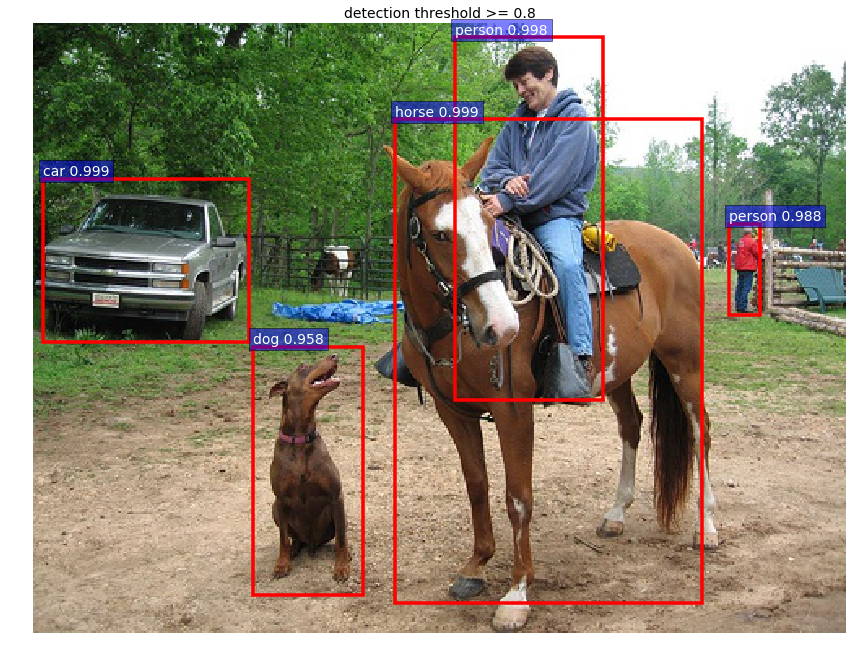

In [12]:
# Convert image from BGR to RGB
imrgb = im[:, :, (2, 1, 0)]
    
# Plot image in figure
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(imrgb, aspect='equal')

# Visualize detections for each class
CONF_THRESH = 0.8
NMS_THRESH = 0.3
ax.set_title(('detection threshold >= {:.1f}').format(CONF_THRESH), fontsize=14)
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)] # Grabs all the (300) rectangles for this class
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis]) # Create a list dets[n] = [x0, y0, x1, y1, score]
                     ).astype(np.float32)                   # Basically, append the score to the rectangle coordinates
    keep = nms(dets, NMS_THRESH) # Non-maximum supression
    dets = dets[keep, :] # Remove non-maxima rectangles from dets
    vis_detections(im, cls, dets, ax, thresh=CONF_THRESH) # Visualize detections

# Draw and show figure
plt.axis('off')
plt.tight_layout()
plt.draw()
plt.show()